In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt                                                       
from matplotlib import cm
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import ezgal # BC03 model maker
import os
from astropy.cosmology import LambdaCDM
import pandas as pd

# All the EzGal stuff

In [3]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

def setup_models(zf, tau):
    #model = ezgal.model('bc03_exp_0.1_z_0.02_salp.model')
    model = ezgal.model('bc03_ssp_z_0.02_chab.model')

    if isinstance(tau, list):
        raise ValueError('tau cannot be a list')
    exp = model.make_exponential(tau)

    # set cosmology
    exp.set_cosmology(Om=0.3, Ol=0.7, h=0.7, w=-1)
    # set the model normalization to Dai et al 2009 (ApJ, 697, 506)
    exp.set_normalization('ch1', 0.24, -25.06, vega=True)
    exp.add_filter('g_MOSAICII.res', name='g')
    exp.add_filter('r_MOSAICII.res', name='r')
    exp.add_filter('i_MOSAICII.res', name='i')
    exp.add_filter('z_MOSAICII.res', name='z')
    exp.add_filter('K_KittPeak.res', name='K')
    exp.set_zfs(zf)

    return exp

model = setup_models(5, 1)

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_chab.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))
/home/boada/.local/lib/python3.6/site-packages/ezgal/cosmology.py:185: RuntimeWarning: divide by zero encountered in log10
  return 5. * num.log10(self.Dl(z) / self.pc / 10)


# Cosmology Stuff

In [4]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)

z = np.arange(0.01, 1.5, 0.01)

dlum = cosmo.luminosity_distance(z)

h = cosmo.H0.value/100

# Calculate some cosmological stuff
DM = cosmo.distmod(z)
dlum = cosmo.luminosity_distance(z)

# Load completeness stuff
from the other notebook

In [11]:
complete = pd.read_csv('./psz_depths.csv')

In [13]:
complete.describe()

,g,r,i,z,K
count,56.000000,56.000000,56.000000,55.000000,80.000000
mean,23.642200,23.370131,23.323245,22.956951,21.318638
std,0.743882,0.738106,0.569614,0.481309,0.681492
min,20.533843,20.048669,21.216852,21.450051,18.801006
25%,23.377925,23.114832,23.107482,22.668354,20.814546
50%,23.761087,23.465553,23.366265,22.992246,21.491795
75%,24.051688,23.797146,23.699036,23.216523,21.823434
max,24.669797,24.345082,24.175711,24.127846,22.167039


# Curve Stuff

<IPython.core.display.Javascript object>


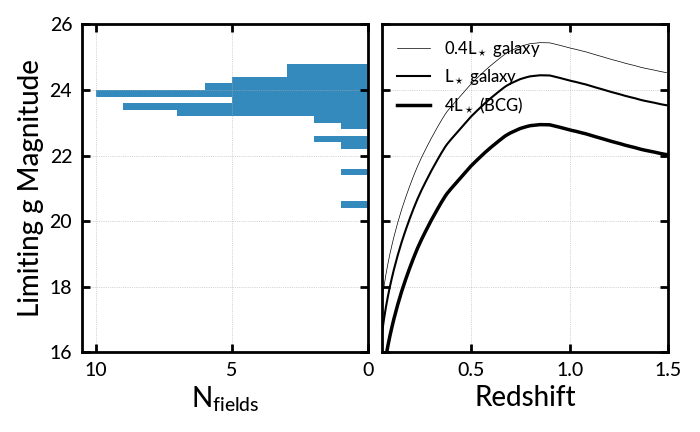

<IPython.core.display.Javascript object>


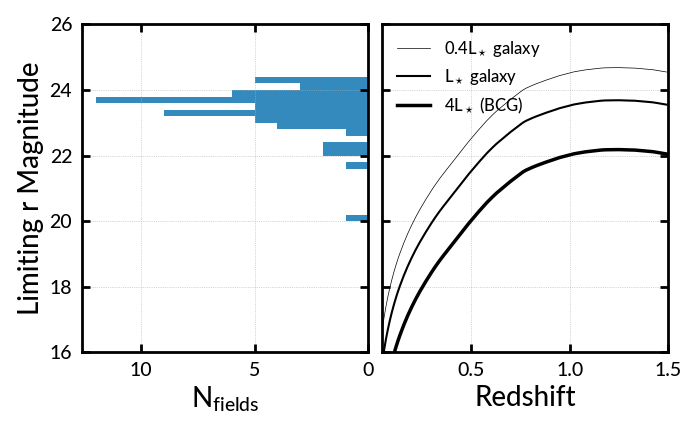

<IPython.core.display.Javascript object>


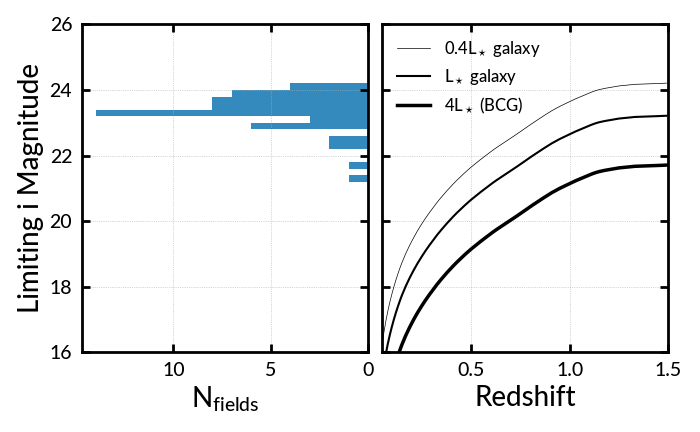

<IPython.core.display.Javascript object>


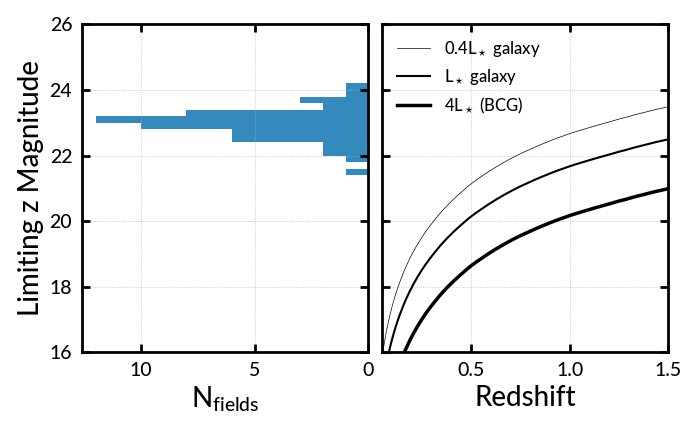

<IPython.core.display.Javascript object>


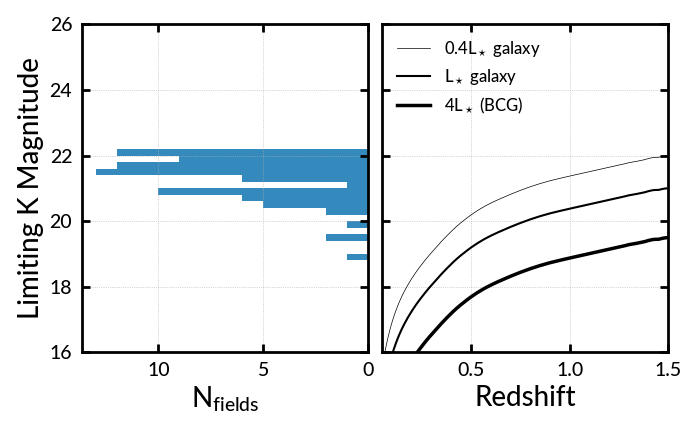

In [45]:
Mr_star = -20.44 + 5 * np.log10(h) # abs mag.
Mi_star = -21.22 - 5 * np.log10(h)
#Mi_star = -20.82

# set the normalization
model.set_normalization('r', 0.1, Mr_star, vega=False)

# now we can calculate the corresponding Mstar values in any other band.
# Remember we defined our model (above) to have a zf=5.
# Blanton is defined at z=0.1
filters = ['g', 'r', 'i', 'z', 'K']
mags = np.arange(16, 26, 0.2)
for filter in filters:
    Mstar = model.get_absolute_mags(5, filters=filter, zs=0.1)

    mstar = (Mstar + DM.value + model.get_kcorrects(5, filters=filter, zs=z) +
          model.get_ecorrects(5, filters=filter, zs=z) -
          model.get_ecorrects(5, filters=filter, zs=0.1))

    LBCG = 4.0
    mstar_sub = mstar - 2.5 * np.log10(0.4)                                 
    BCG = mstar - 2.5 * np.log10(LBCG)
    
    # make some plots
    plt.figure(figsize=(7, 7 * (np.sqrt(5.) - 1.0) / 2.0))              
    ax = plt.subplot2grid((1, 4), (0, 0), colspan=2)                           
    axs = plt.subplot2grid((1, 4), (0, 2), colspan=2)
                                                                               
    ax.hist(complete[filter].values, bins=mags, color='#348abd',
              orientation='horizontal', histtype='stepfilled')
    # flip the axis
    ax.invert_xaxis()
    ax.set_xlabel('$N_{fields}$')
    ax.set_ylabel(f'Limiting {filter} Magnitude')
    
    axs.plot(z, mstar_sub, 'k-', linewidth=0.5, label='$0.4L_\star$ galaxy')
    axs.plot(z, mstar, 'k-', linewidth=1.5, label='$L_\star$ galaxy')
    axs.plot(z, BCG, 'k-', linewidth=2.5, label='$%dL_\star$ (BCG)' % LBCG)
    axs.set_xlabel('Redshift')
    #axs.set_ylabel(f'{filter} mag')
    axs.legend(loc='upper left', fancybox=True, shadow=True)

    axs.set_xlim(0.05, 1.5)                                                   
    axs.set_ylim(16, 26)
    ax.set_ylim(16, 26)    
    
    axs.set_yticklabels([])
    ax.grid()
    axs.grid()
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1)
    
    